In [121]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile

import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [370]:
file = open('./.env')
api = file.read()

In [371]:
def get_stock(symbol):
    # Check if symbol exists as csv in current directory
    if isfile('./stock_data/' + symbol + '.csv'):
        # return our stored dataframe and with 'Date' as index
        stock = pd.read_csv('./stock_data/' + symbol + '.csv', index_col="Date")
        # Make the index into DateTime
        stock.index = pd.to_datetime(stock.index)
        print('File already exists...')
        # Return our DataFrame in reverse (oldest year to current)
        return stock.iloc[::-1]
    # If it doesn't exit, get data and store it:
    else: 
        API_KEY = api
        r = requests.get(f'https://www.worldtradingdata.com/api/v1/history?symbol={symbol}&sort=newest&api_token={API_KEY}')
        # Use eval to disregard the type str
        data = eval(r.text)
        stock = pd.DataFrame(data['history'])
        # Transpose the df 
        stock = stock.T
        # Make the index into DateTime
        stock.index = pd.to_datetime(stock.index)
        # Make index name 'Date'
        stock.index.name = 'Date'
        # Creates a csv file with complete stock history
        stock.to_csv('./stock_data/' + symbol + '.csv')
        # Return our DataFrame in reverse (oldest year to current)
        return stock.iloc[::-1]

In [372]:
# Call our function with desired stock (Netflix) to get stock information and store it in a variable
AAPL = get_stock('AAPL')

File already exists...


In [373]:
AAPL.head()

,close,high,low,open,volume
Date,,,,,
1980-12-12,0.51,0.52,0.51,0.51,2093900
1980-12-15,0.49,0.49,0.49,0.49,785200
1980-12-16,0.45,0.45,0.45,0.45,472000
1980-12-17,0.46,0.46,0.46,0.46,385900
1980-12-18,0.48,0.48,0.48,0.48,327900


In [374]:
AAPL['close'] = pd.to_numeric(AAPL['close'])

In [375]:
# Split our data up into months by the average closing price per month
AAPL = pd.DataFrame(AAPL['close'].resample('MS').mean())

In [376]:
AAPL = pd.DataFrame(AAPL)

In [377]:
AAPL.head()

,close
Date,
1980-12-01,0.543077
1981-01-01,0.564762
1981-02-01,0.472105
1981-03-01,0.444091
1981-04-01,0.485714


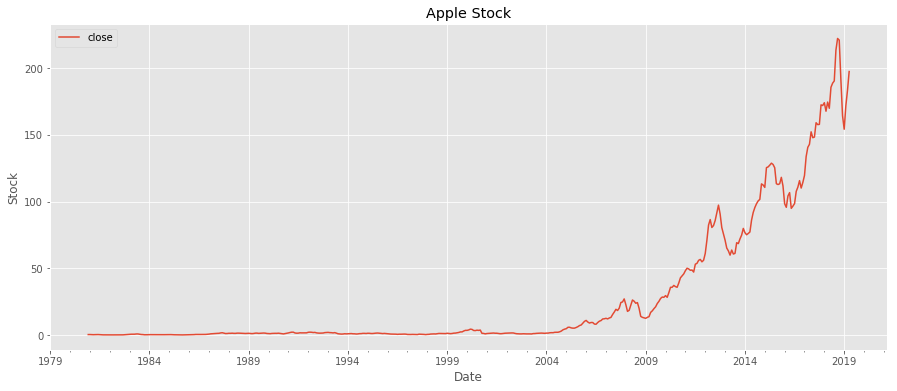

In [378]:
AAPL.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Stock')
plt.title('Apple Stock')
plt.show()

In [379]:
# Determining rolling statistics
rolmean = AAPL.rolling(window=12).mean()
rolstd = AAPL.rolling(window=12).std()

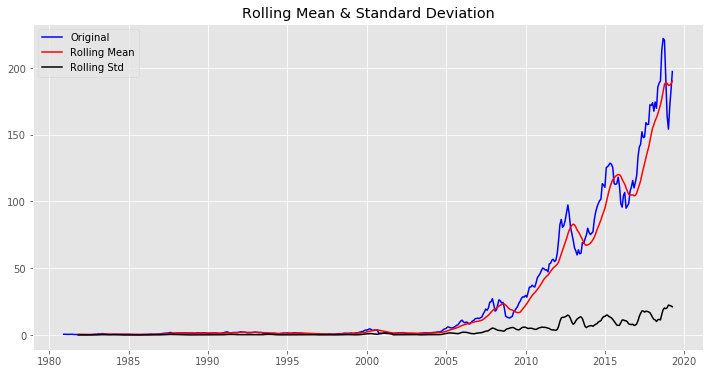

In [380]:
#Plot rolling statistics:
fig = plt.figure(figsize=(12,6))
orig = plt.plot(AAPL, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False) 

> From above, we can clearly see that our data is not stationary

In [381]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')

dftest = adfuller(AAPL['close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   3.277885
p-value                          1.000000
#Lags Used                      18.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


> 1. Our p-value should usually be less than or around 0.05 <br>
> 2. Our Critical Values should be greater than our Test Statistic

> Based on our Dickey-Fuller test above, both 1 and 2 are false so we can not reject the null hypothesis and we therefore say that our data is not stationary. 

In [382]:
# Import the check_stationarity function from previous lab
def stationarity_check(TS):

    # Calculate rolling statistics
    rolmean = TS.rolling(window = 12).mean()
    rolstd = TS.rolling(window = 12).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['close'], autolag='AIC') # change the passengers column as required 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

In [388]:
AAPL['close_log'] = AAPL['close'].apply(lambda x: np.log(x))

AAPL['close_log_moving_avg'] = AAPL['close_log'].rolling(window = 12, center = False).mean()

AAPL['close_moving_avg'] = AAPL['close'].rolling(window = 12, center = False).mean()

AAPL['close_log_diff'] = AAPL['close_log'] - AAPL['close_log'].shift()

AAPL['close_log_diff'] = AAPL['close_log'].diff()

AAPL['close_log_moving_avg_diff'] = AAPL['close_log'] - AAPL['close_log_moving_avg']

AAPL_transform = AAPL.dropna()

AAPL_transform['close_log_ewma'] = AAPL_transform['close_log'].ewm(halflife=7, ignore_na=False, min_periods=0, adjust=True).mean()

AAPL_transform['close_log_ewma_diff'] = AAPL_transform['close_log'] - AAPL_transform['close_log_ewma']



## Decomposing

Time series decomposition is a mathematical procedure which transforms a time series into multiple different time series. The original time series is often split into 3 component series:

>Seasonal: Patterns that repeat with a fixed period of time. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.

>Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.

>Random: Also call “noise”, “irregular” or “remainder,” this is the residuals of the original time series after the seasonal and trend series are removed.

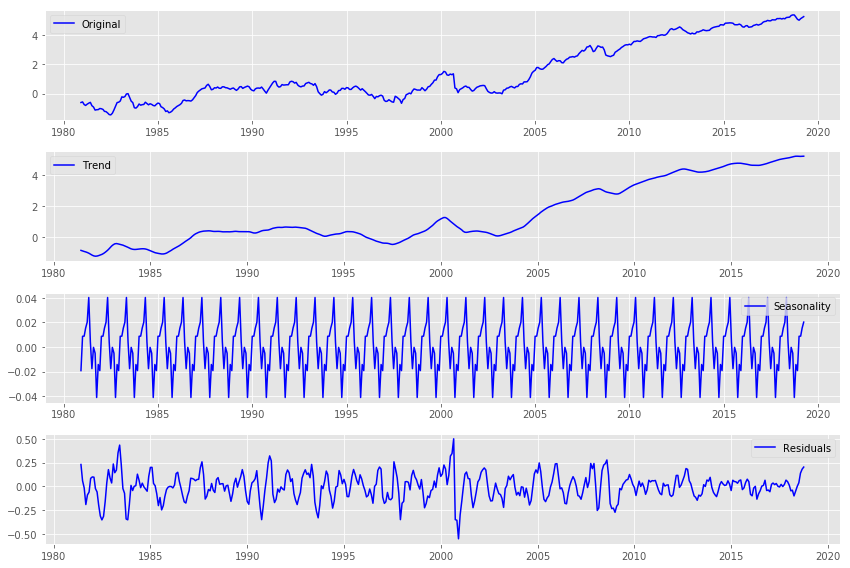

In [145]:
decomposition = sm.tsa.seasonal_decompose(AAPL_log)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(AAPL_log, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

##  PACF and ACF
> The shaded area is 95% confidence interval.
>> Anything outside the colored region is statisitically significant <br>
>> Anything inside the colored region is not statistically significant

### ACF

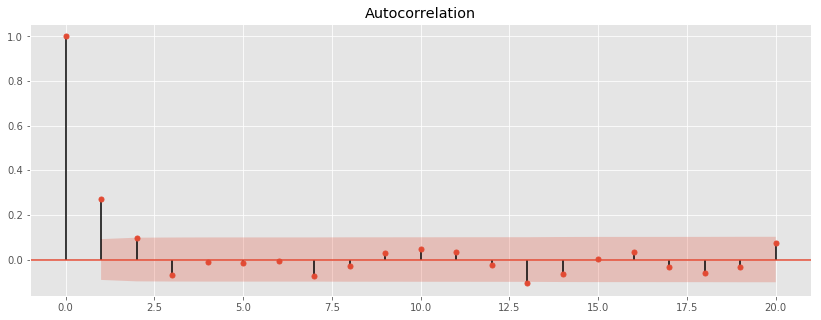

In [147]:
rcParams['figure.figsize'] = 14, 5

plot_acf(AAPL_shift_diff, lags = 20);

### PACF

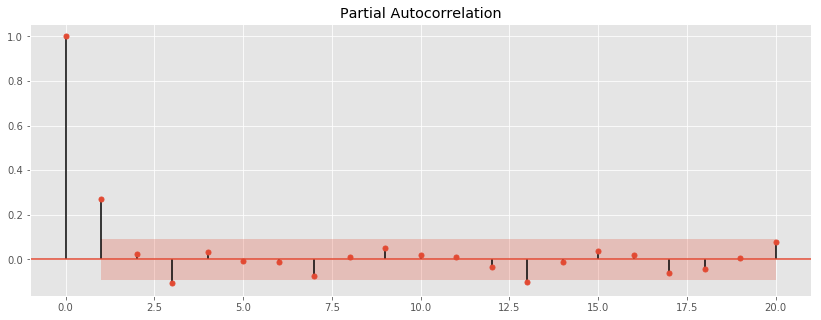

In [148]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(AAPL_shift_diff, lags = 20);

# ARIMA Modeling

>The first step towards fitting an ARIMA model is to find the values of ARIMA(p,d,q) that produce the desired output. Selection of these parameters requires domain expertise and time. We shall first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters.

> 1. AR = p = autoregressive lags
> 2. MA = q = moving average
> 3. I = d = order of differentiation

In [252]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## AIC (Akaike Information Criterion)

> The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

> A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [325]:
AAPL_train= AAPL[AAPL.index < '2014-01-01']
AAPL_test = AAPL[AAPL.index >= '2014-01-01']
AAPL_test.index[0]

Timestamp('2014-01-01 00:00:00', freq='MS')

In [257]:
AAPL_log_train= AAPL_log[AAPL_log.index < '2014-01-01']
AAPL_log_test = AAPL_log[AAPL_log.index >= '2014-01-01']
AAPL_log_test.index[0]

Timestamp('2014-01-01 00:00:00', freq='MS')

In [353]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(AAPL_log_train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1604.945207107468
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1196.2950867914792
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =617.4624141969355
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =601.7779200628918
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =614.0158353580787
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =614.1661735692081
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =603.0479285349039
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =582.8239800239268
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1098.7018763415726
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =727.5477965516159
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =209.8551603035909
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =204.23589071695102
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =210.6772180308733
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =208.07423185665718
ARIMA (0, 0, 1) 

In [354]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 0)
pdqs    (0, 0, 0, 12)
aic          -567.034
Name: 48, dtype: object

## Model Fitting

> In the simple grid example above, we identified the set of parameters that produced the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

In [355]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(AAPL_log_train,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2978      0.045      6.564      0.000       0.209       0.387
ar.S.L12      -0.0607      0.060     -1.019      0.308      -0.178       0.056
ma.S.L12      -1.0001     38.234     -0.026      0.979     -75.938      73.938
sigma2         0.0132      0.506      0.026      0.979      -0.978       1.005


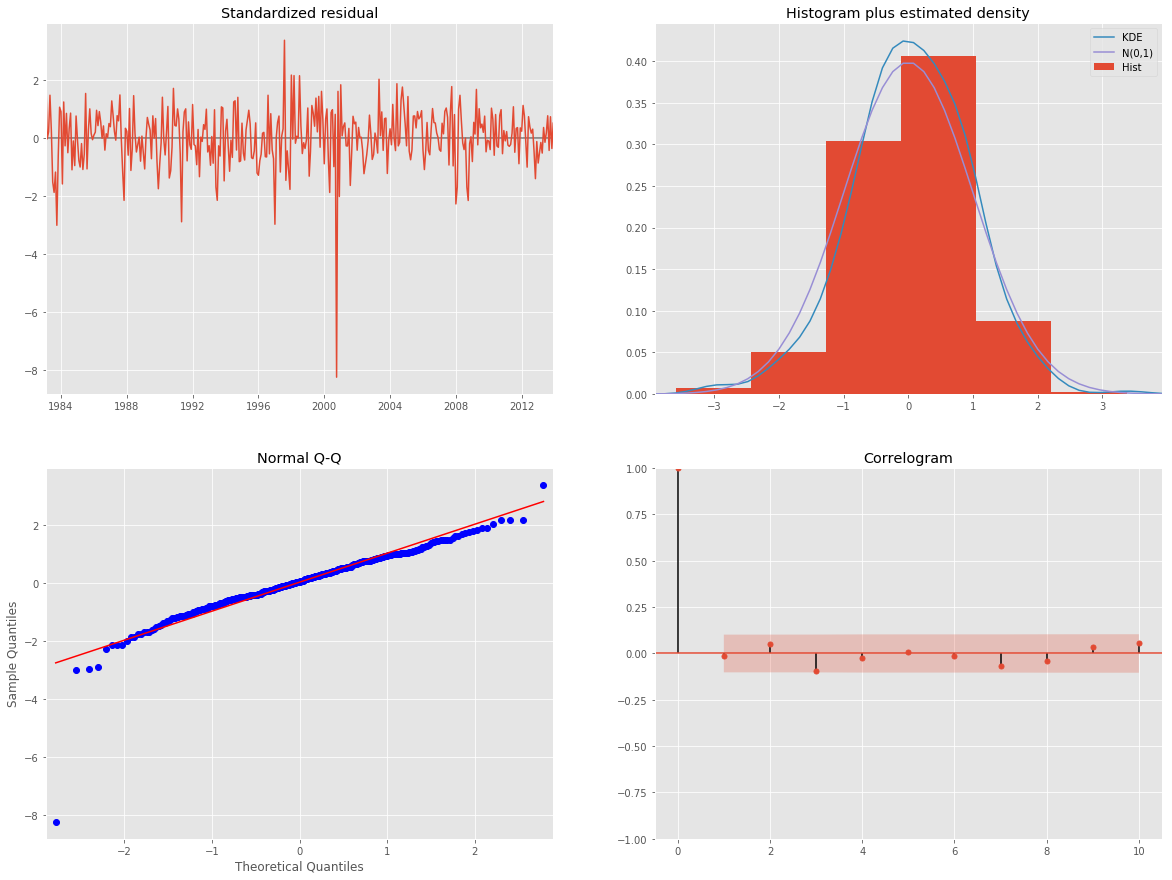

In [356]:
output.plot_diagnostics(figsize=(20, 15))
plt.show()

> Let's check for these assumptions from diagnostics plots.

> In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

> The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

> The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## Validating the Model

In [357]:
pred = output.get_prediction(start=AAPL_test.index[0], end=AAPL_test.index[-1], dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower close,upper close
2014-01-01,4.227988,4.685754
2014-02-01,4.103958,4.853933
2014-03-01,4.010401,4.992869
2014-04-01,3.940159,5.116385
2014-05-01,3.889855,5.233893
2014-06-01,3.781535,5.275110
2014-07-01,3.706613,5.336187
2014-08-01,3.670079,5.425179
2014-09-01,3.626640,5.498878
2014-10-01,3.536872,5.519339


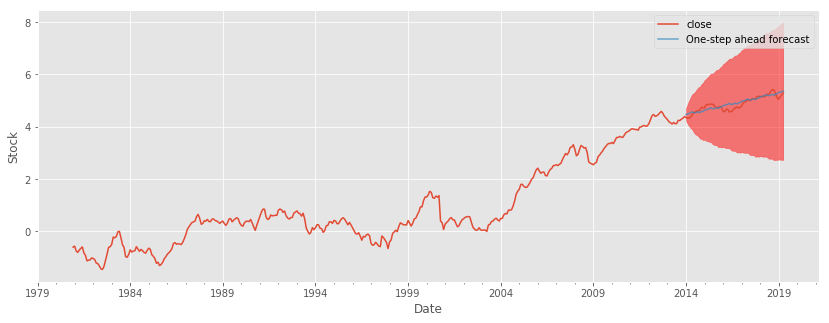

In [358]:
ax = AAPL_log['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Date')
ax.set_ylabel('Stock')
plt.legend()

plt.show()

## Mean Squared Error

In [359]:
# Get the Real and predicted values
y_forecasted = pred.predicted_mean
y_truth = AAPL_log[AAPL_test.index[0]:]

# Calculate MSE
mse = mean_squared_error(y_truth, y_forecasted)

print(f'The Mean Squared Error of our forecasts is {(round(mse, 2))}.')

The Mean Squared Error of our forecasts is 0.02.


## Root Mean Squared Error

In [360]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}.')

The Root Mean Squared Error of our forecasts is 0.14.


## Dynamic Forcasting

> We can achieve a deeper insight into model's predictive power using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In [361]:
pred_dynamic = output.get_prediction(start=AAPL_test.index[0], end=AAPL_test.index[-1], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

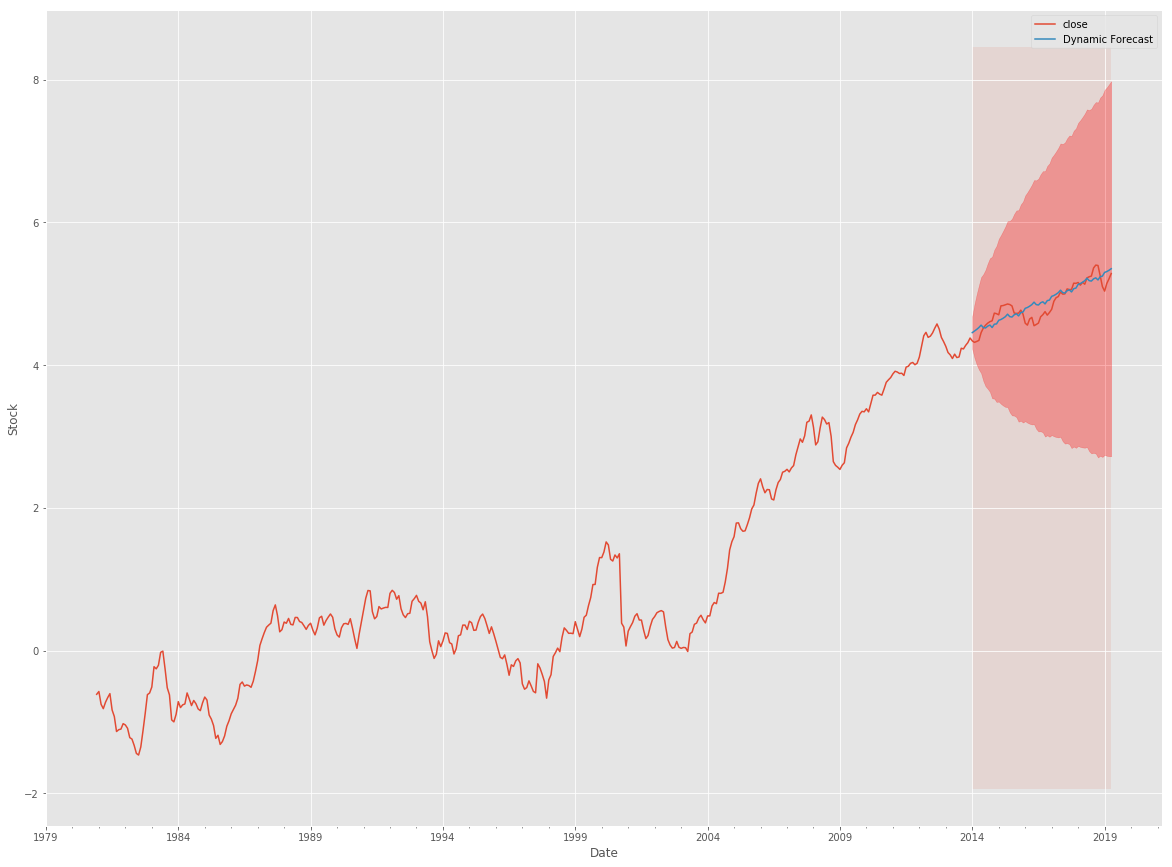

In [362]:
# Plot the dynamic forecast with confidence intervals.

ax = AAPL_log['1980':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], 
                color='r', 
                alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2014-01-01'), 
                 AAPL.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Stock')

plt.legend()
plt.show()

## Mean Squared Error

In [363]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = AAPL_log[AAPL_test.index[0]:]

# Compute the mean square error
mse = mean_squared_error(y_truth, y_forecasted)
print(f'The Mean Squared Error of our forecasts is {(round(mse, 2))}.')

The Mean Squared Error of our forecasts is 0.02.


## Root Mean Squared Error

In [364]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}.')

The Root Mean Squared Error of our forecasts is 0.14.


## Producing and Visualizing Forecasts

In [365]:
# Get forecast of 5 years or 60 months steps ahead in future
forecast = output.get_forecast(steps=120)
# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()

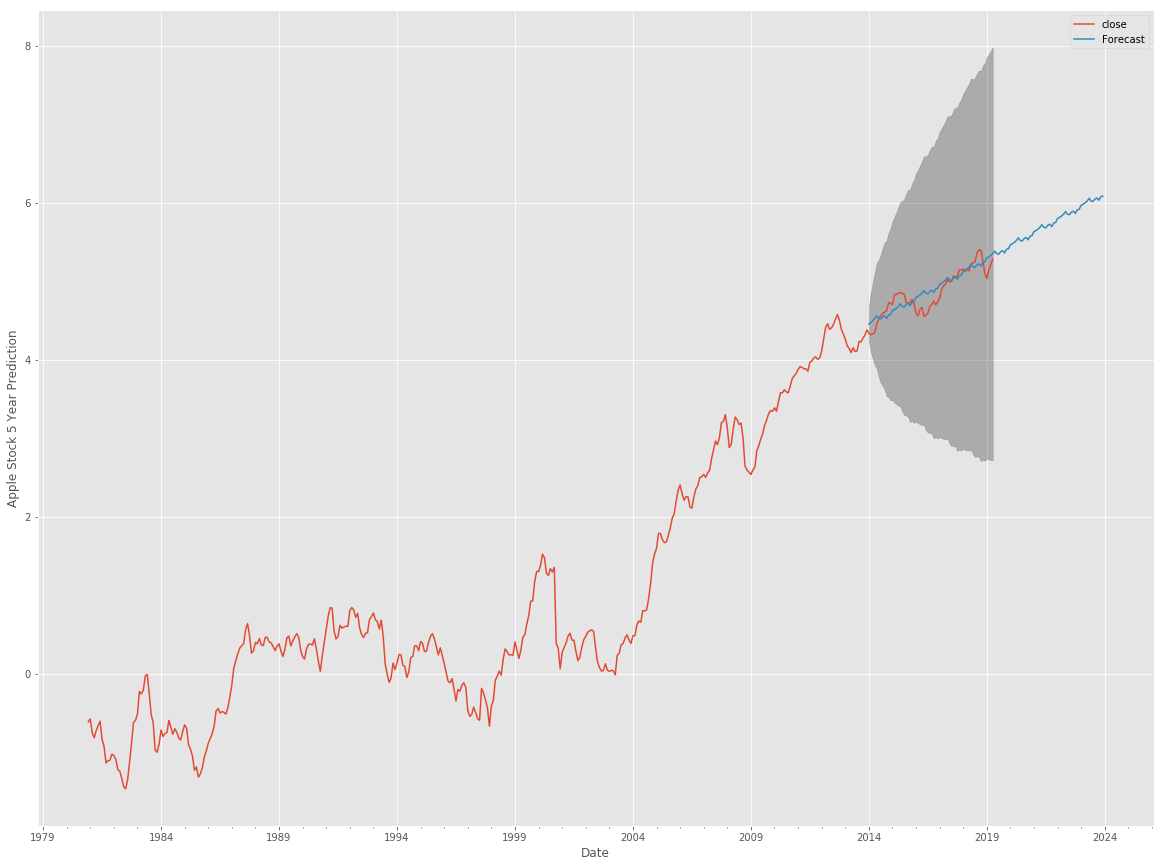

In [366]:
# Plot future predictions with confidence intervals

ax = AAPL_log.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Apple Stock 5 Year Prediction')

plt.legend()
plt.show()

## Facebook Prophet

In [92]:
from fbprophet import Prophet as proph

In [93]:
model = proph(interval_width=0.95)

In [94]:
AAPL.rename(columns={'close':'y'}, inplace=True)
AAPL.index.names = ['ds']
AAPL.reset_index(inplace=True)

In [95]:
AAPL.tail()

,ds,y
456,2018-12-01,164.266316
457,2019-01-01,154.166190
458,2019-02-01,171.727895
459,2019-03-01,183.293810
460,2019-04-01,197.324545


In [96]:
model.fit(AAPL)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [97]:
future_dates = model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()

,ds
492,2021-12-01
493,2022-01-01
494,2022-02-01
495,2022-03-01
496,2022-04-01


In [98]:
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-12-01,0.271797,-17.419428,16.536317,0.271797,0.271797,-0.711978,-0.711978,-0.711978,-0.711978,-0.711978,-0.711978,0.0,0.0,0.0,-0.440181
1,1981-01-01,0.276999,-17.004863,16.249326,0.276999,0.276999,-0.899892,-0.899892,-0.899892,-0.899892,-0.899892,-0.899892,0.0,0.0,0.0,-0.622894
2,1981-02-01,0.282200,-16.019506,15.477250,0.282200,0.282200,-0.471683,-0.471683,-0.471683,-0.471683,-0.471683,-0.471683,0.0,0.0,0.0,-0.189483
3,1981-03-01,0.286898,-15.288055,16.536737,0.286898,0.286898,0.113906,0.113906,0.113906,0.113906,0.113906,0.113906,0.0,0.0,0.0,0.400804
4,1981-04-01,0.292100,-15.549753,17.956796,0.292100,0.292100,0.375425,0.375425,0.375425,0.375425,0.375425,0.375425,0.0,0.0,0.0,0.667524


In [99]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
492,2021-12-01,222.653709,205.440423,240.650364
493,2022-01-01,223.418106,207.000318,241.161567
494,2022-02-01,225.335554,207.650785,243.436972
495,2022-03-01,227.402665,210.932798,245.172069
496,2022-04-01,229.190778,212.800478,246.671210


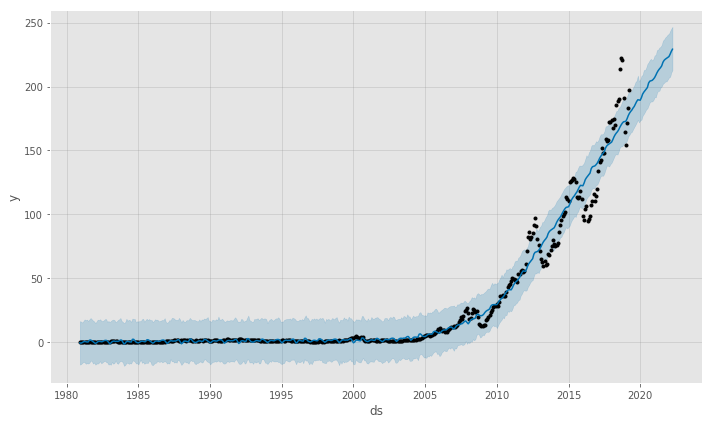

In [100]:
model.plot(forecast, uncertainty=True)
plt.show();

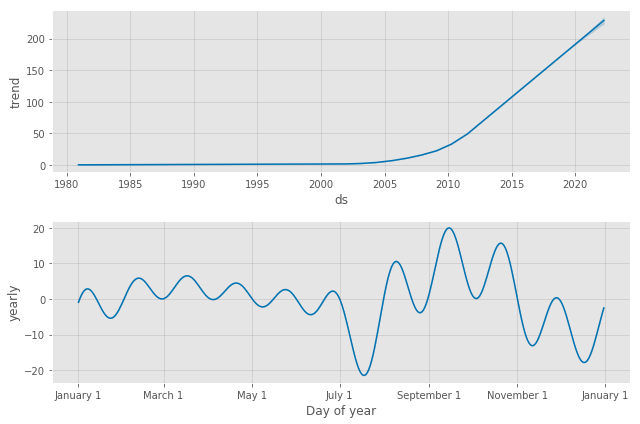

In [101]:
model.plot_components(forecast);